<a href="https://colab.research.google.com/github/dkalenov/ML-Stock-Crypto-Trading/blob/2_supervised-learning/Bitcoin_Move_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bitcoin Move Prediction Model-1

## Case Study

Crypto exchanges (e.g. Bybit) allow customers to trade based on the size of Move for Bitcoin. If we can determine a model, which can forecast better than 50/50 accuracy, whether or not Bitcoins move will likely be above it's average, then we have an edge.

The catch is, how to predict whether future volatility will be above or below the rolling average (assuming that the rolling average is where the market adjusts to). Regardless, this will be a significant challenge and we will need state-of-the-art methods, whilst making sure we do not overfit.

## Data_Preprocessing

### Imports

In [ ]:
!pip install ta

In [ ]:
import numpy as np
import pandas as pd
import sklearn.mixture as mix
from ta.momentum import RSIIndicator
import matplotlib.pyplot as plt

In [ ]:
 !pip install pandas-datareader

### Data Extraction and Returns Overview

In [ ]:
import numpy as np
import yfinance as yf

# Create the class
class StrategyManager():

    # Initialize the class
    def __init__(self, symbol, start_date, end_date):
        self.df = self._extract_data(symbol, start_date, end_date)
        self.sharpe = 0

    # Extract data
    def _extract_data(self, symbol, start_date, end_date):
        from pandas_datareader.data import DataReader
        data = yf.download(symbol, start_date, end_date)
        #data = DataReader(name=symbol, data_source='yahoo', start=start_date, end=end_date)
        data = data[["Open", "High", "Low", "Close", "Volume"]]
        data = self._structure_df(data)
        return data

    # Calculates general period returns and volatility
    def _structure_df(self, df):
        df["Returns"] = df["Close"].pct_change()
        df["Range"] = df["High"] / df["Low"] - 1
        df["Bench_C_Rets"], sharpe = self._calculate_returns(df, True)
        self.sharpe = sharpe
        df.dropna(inplace=True)
        return df

    # Adjusts the signal to represent our strategy
    def _set_multiplier(self, direction):
        if direction == "long":
            pos_multiplier = 1
            neg_multiplier = 0
        elif direction == "long_short":
            pos_multiplier = 1
            neg_multiplier = -1
        else:
            pos_multiplier = 0
            neg_multiplier = -1
        return pos_multiplier, neg_multiplier

    # Calculates returns for equity curve
    def _calculate_returns(self, df, is_benchmark):

        # Calculate multiplier
        if not is_benchmark:
            multiplier_1 = df["Signal"]
            multiplier_2 = 1 if "PSignal" not in df.columns else df["PSignal"]
            log_rets = np.log(df["Close"] / df["Close"].shift(1)) * multiplier_1 * multiplier_2
        else:
            multiplier_1 = 1
            multiplier_2 = 1

            # Assume open price on following day to avoid lookahead bias for close calculation
            log_rets = np.log(df["Open"].shift(-1) / df["Close"].shift(1)) * multiplier_1 * multiplier_2

        # Calculate Sharpe Ratio
        sharpe_ratio = self.sharpe_ratio(log_rets)

        # Calculate Cumulative Returns
        c_log_rets = log_rets.cumsum()
        c_log_rets_exp = np.exp(c_log_rets) - 1

        # Return result and Sharpe ratio
        return c_log_rets_exp, sharpe_ratio

    def sharpe_ratio(self, return_series):
        N = 255 # Trading days in the year (change to 365 for crypto)
        rf = 0.005 # Half a percent risk free rare
        mean = return_series.mean() * N -rf
        sigma = return_series.std() * np.sqrt(N)
        sharpe = round(mean / sigma, 3)
        return sharpe

    # Replace Dataframe
    def change_df(self, new_df, drop_cols=[]):
        new_df = new_df.drop(columns=drop_cols)
        self.df = new_df

    # Moving average crossover strategy
    def backtest_ma_crossover(self, period_1, period_2, direction, drop_cols=[]):

        # Set df
        df = self.df

        # Get multipliers
        pos_multiplier, neg_multiplier = self._set_multiplier(direction)

        # Calculate Moving Averages
        if f"MA_{period_1}" or f"MA_{period_2}" not in df.columns:
            df[f"MA_{period_1}"] = df["Close"].rolling(window=period_1).mean()
            df[f"MA_{period_2}"] = df["Close"].rolling(window=period_2).mean()
            df.dropna(inplace=True)

        # Calculate Benchmark Returns
        df["Bench_C_Rets"], sharpe_ratio_bench = self._calculate_returns(df, True)

        # Calculate Signal
        df.loc[df[f"MA_{period_1}"] > df[f"MA_{period_2}"], "Signal"] = pos_multiplier
        df.loc[df[f"MA_{period_1}"] <= df[f"MA_{period_2}"], "Signal"] = neg_multiplier

        # Calculate Strategy Returns
        df["Strat_C_Rets"], sharpe_ratio_strat = self._calculate_returns(df, False)

        # Get values for output
        bench_rets = df["Bench_C_Rets"].values.astype(float)
        strat_rets = df["Strat_C_Rets"].values.astype(float)
        print("Sense check: ", round(df["Close"].values[-1] / df["Close"].values[0] - 1, 3), round(bench_rets[-1], 3))

        # Remove irrelevant features
        if len(drop_cols) > 0:
            df = df.drop(columns=drop_cols)

        # Ensure Latest DF matches
        df = df.dropna()
        self.df = df

        # Return df
        return df, sharpe_ratio_bench, sharpe_ratio_strat

In [ ]:
# Extract Data
start_date = "2017-01-01"
end_date = "2024-04-20"
symbol = "BTC-USD"
strat_mgr = StrategyManager(symbol, start_date, end_date)
df = strat_mgr.df.copy()
df.tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets
Date,,,,,,,,
2024-04-11,70575.734375,71256.234375,69571.812500,70060.609375,30153382941,-0.007470,0.024211,80.725996
2024-04-12,70061.382812,71222.742188,65254.835938,67195.867188,44129299406,-0.040889,0.091455,77.375523
2024-04-13,67188.375000,67931.429688,60919.105469,63821.472656,52869738185,-0.050217,0.115109,73.456929
2024-04-14,63836.230469,65824.429688,62205.851562,65738.726562,49084320047,0.030041,0.058171,75.694757
2024-04-15,65739.648438,66878.648438,62332.070312,63426.210938,43595917654,-0.035177,0.072941,73.463328


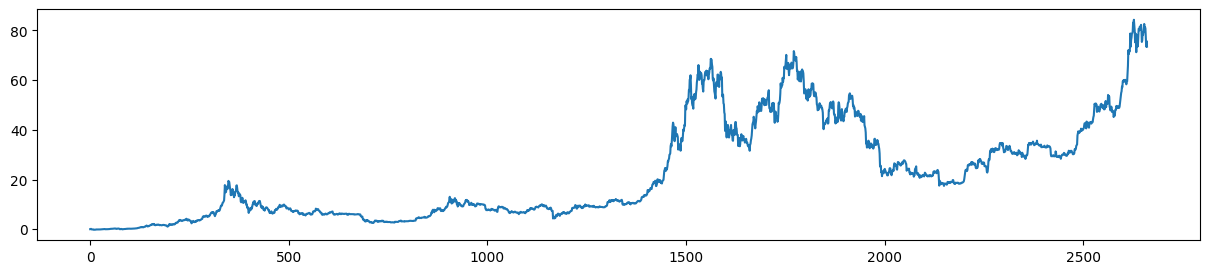

In [ ]:
# Benchmark Returns Profile
fig = plt.figure(figsize = (15, 3))
plt.plot(df["Bench_C_Rets"].values)
plt.show()

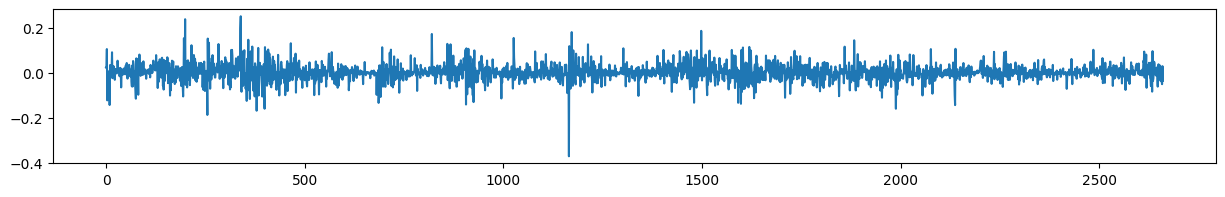

In [ ]:
# Benchmark Returns Profile
fig = plt.figure(figsize = (15, 2))
plt.plot(df["Returns"].values)
plt.show()

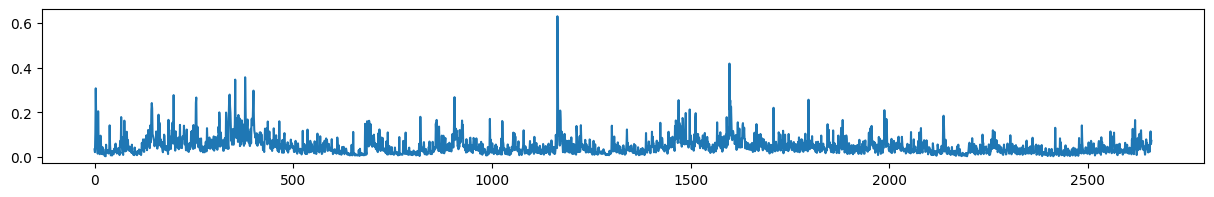

In [ ]:
# Benchmark Range Profile
fig = plt.figure(figsize = (15, 2))
plt.plot(df["Range"].values)
plt.show()

### Feature Engineering - Feature Expansion

In [ ]:
# Create a copy
df_fe = df.copy()

##### Indicators

In [ ]:
# Add RSI(Relative Strength Index) RSI helps to assess the level of overbought or oversold an asset and the expected strength of the current trend.
rsi = RSIIndicator(close=df_fe["Close"], window=14).rsi()
df_fe["RSI"] = rsi
df_fe["RSI_Ret"] = df_fe["RSI"] / df_fe["RSI"].shift(1)

In [ ]:
# Add Moving Average
df_fe["MA_12"] = df_fe["Close"].rolling(window=12).mean()
df_fe["MA_21"] = df_fe["Close"].rolling(window=21).mean()

In [ ]:
# Day of Week
df_fe["DOW"] = df_fe.index.dayofweek

In [ ]:
# Rolling Cumulative Returns
df_fe["Roll_Rets"] = df_fe["Returns"].rolling(window=30).sum()

In [ ]:
# Rolling Cumulative Range
df_fe["Avg_Range"] = df_fe["Range"].rolling(window=30).mean()

##### Time Intervals

In [ ]:
# Add Time Intervals
t_steps = [1, 2]
t_features = ["Returns", "Range", "RSI_Ret"]
for ts in t_steps:
    for tf in t_features:
        df_fe[f"{tf}_T{ts}"] = df_fe[tf].shift(ts)

In [ ]:
# Show DataFrame
df_fe.head(3)

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Ret,...,MA_21,DOW,Roll_Rets,Avg_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-02,998.617004,1031.390015,996.702026,1021.750000,222184992,0.023464,0.034803,0.023314,NaN,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,185168000,0.021620,0.022005,0.045999,NaN,NaN,...,NaN,1,NaN,NaN,0.023464,0.034803,NaN,NaN,NaN,NaN
2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,344945984,0.106233,0.110130,0.159122,NaN,NaN,...,NaN,2,NaN,NaN,0.021620,0.022005,NaN,0.023464,0.034803,NaN


### Feature Engineering - Feature Scaling

In [ ]:
# Correct for Stationarity
df_fs = df_fe.copy()
df_fs[["Open", "High", "Low", "Volume"]] = df_fs[["Open", "High", "Low", "Volume"]].pct_change()
df_fs

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Ret,...,MA_21,DOW,Roll_Rets,Avg_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-02,NaN,NaN,NaN,1021.750000,NaN,0.023464,0.034803,0.023314,NaN,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-03,0.023015,0.012304,0.024980,1043.839966,-0.166604,0.021620,0.022005,0.045999,NaN,NaN,...,NaN,1,NaN,NaN,0.023464,0.034803,NaN,NaN,NaN,NaN
2017-01-04,0.022318,0.110471,0.022318,1154.729980,0.862881,0.106233,0.110130,0.159122,NaN,NaN,...,NaN,2,NaN,NaN,0.021620,0.022005,NaN,0.023464,0.034803,NaN
2017-01-05,0.107555,0.027324,-0.128287,1013.380005,0.479069,-0.122410,0.308302,0.018098,NaN,NaN,...,NaN,3,NaN,NaN,0.106233,0.110130,NaN,0.021620,0.022005,NaN
2017-01-06,-0.123183,-0.121140,-0.029078,902.200989,-0.310316,-0.109711,0.184249,-0.092307,NaN,NaN,...,NaN,4,NaN,NaN,-0.122410,0.308302,NaN,0.106233,0.110130,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-11,0.020762,0.002290,0.030639,70060.609375,-0.213088,-0.007470,0.024211,80.725996,54.781311,0.976951,...,68726.086310,3,1.061867e-07,0.053544,0.020956,0.053180,1.052829,-0.034794,0.051744,0.897683
2024-04-12,-0.007288,-0.000470,-0.062051,67195.867188,0.463494,-0.040889,0.091455,77.375523,48.271370,0.881165,...,68888.805618,4,-6.330379e-02,0.055516,-0.007470,0.024211,0.976951,0.020956,0.053180,1.052829
2024-04-13,-0.041007,-0.046212,-0.066443,63821.472656,0.198064,-0.050217,0.115109,73.456929,41.947971,0.869003,...,68877.342262,5,-9.043918e-02,0.056831,-0.040889,0.091455,0.881165,-0.007470,0.024211,0.976951


### Assess Data for ML Readiness

In [ ]:
# Check for NaN
df_fs.dropna(inplace=True)
print(df_fs.isnull().values.any())

False


In [ ]:
# Check for Inf values
dfobj = df_fs.isin([np.inf, -np.inf])
count = np.isinf(dfobj).values.sum()
count

0

In [ ]:
# Check for non-numerical objects
df_fs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2632 entries, 2017-01-31 to 2024-04-15
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          2632 non-null   float64
 1   High          2632 non-null   float64
 2   Low           2632 non-null   float64
 3   Close         2632 non-null   float64
 4   Volume        2632 non-null   float64
 5   Returns       2632 non-null   float64
 6   Range         2632 non-null   float64
 7   Bench_C_Rets  2632 non-null   float64
 8   RSI           2632 non-null   float64
 9   RSI_Ret       2632 non-null   float64
 10  MA_12         2632 non-null   float64
 11  MA_21         2632 non-null   float64
 12  DOW           2632 non-null   int32  
 13  Roll_Rets     2632 non-null   float64
 14  Avg_Range     2632 non-null   float64
 15  Returns_T1    2632 non-null   float64
 16  Range_T1      2632 non-null   float64
 17  RSI_Ret_T1    2632 non-null   float64
 18  Returns_T2

In [ ]:
# Describe DataFrame
df_fs.describe()

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Ret,...,MA_21,DOW,Roll_Rets,Avg_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2
count,2632.000000,2632.000000,2632.000000,2632.000000,2632.000000,2632.000000,2632.000000,2632.000000,2632.000000,2632.000000,...,2632.000000,2632.00000,2632.000000,2632.000000,2632.000000,2632.000000,2632.000000,2632.000000,2632.000000,2632.000000
mean,0.002358,0.002186,0.002349,20896.625226,0.042308,0.002345,0.049833,22.558304,53.404058,1.005132,...,20642.552489,3.00000,0.071279,0.049740,0.002359,0.049807,1.005167,0.002347,0.049787,1.005125
std,0.038235,0.033595,0.038206,17466.525617,0.322162,0.038243,0.042260,19.881845,14.471982,0.104597,...,17171.442728,2.00038,0.232864,0.023589,0.038236,0.042267,0.104582,0.038233,0.042276,0.104565
min,-0.365924,-0.263712,-0.364062,937.520020,-0.869188,-0.371695,0.003596,-0.044698,9.920239,0.453659,...,885.613522,0.00000,-0.844981,0.015756,-0.371695,0.003596,0.453659,-0.371695,0.003596,0.453659
25%,-0.013761,-0.011259,-0.011134,7190.725220,-0.134013,-0.013877,0.023322,6.716387,43.285420,0.955054,...,7201.079875,1.00000,-0.067783,0.033364,-0.013863,0.023285,0.955161,-0.013863,0.023248,0.955161
50%,0.001380,-0.000237,0.002891,12698.750977,-0.006861,0.001377,0.038620,12.579209,52.391182,1.004029,...,11997.557710,3.00000,0.044631,0.044122,0.001377,0.038583,1.004029,0.001367,0.038561,1.003987
75%,0.018691,0.014451,0.017004,31840.586426,0.163516,0.018544,0.061032,34.694139,62.917815,1.047123,...,32197.645624,5.00000,0.221136,0.059014,0.018544,0.061020,1.047123,0.018533,0.061020,1.047084
max,0.250461,0.245708,0.247892,73083.500000,5.439003,0.252472,0.631387,84.255882,94.302215,1.926078,...,68888.805618,6.00000,1.154731,0.138628,0.252472,0.631387,1.926078,0.252472,0.631387,1.926078


### Add all ta features

In [ ]:
# Add TA
from ta import add_all_ta_features
from statsmodels.tsa.stattools import adfuller

df_f = add_all_ta_features(df_fs, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)
df_f

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Ret,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-31,0.000878,0.053054,0.001615,970.403015,1.103895,0.054348,0.055442,-0.029463,60.205366,1.192634,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,970.403015,0.000000,0.000000,0.000000
2017-02-01,0.054272,0.017587,0.054056,989.023010,-0.087932,0.019188,0.018926,-0.009863,63.109498,1.048237,...,0.152849,0.030570,0.122279,-9.361307,-1.872261,-7.489045,980.150348,1.918790,1.900613,1.918790
2017-02-02,0.019630,0.024675,0.012855,1011.799988,-0.028572,0.023030,0.030816,0.012600,66.345006,1.051268,...,0.456440,0.115744,0.340696,-17.451835,-4.988176,-12.463659,997.713117,2.302978,2.276859,4.265957
2017-02-03,0.021676,0.020079,0.026005,1029.910034,0.380309,0.017899,0.024861,0.032145,68.695922,1.035435,...,0.834173,0.259430,0.574743,-20.409765,-8.072494,-12.337271,1014.429338,1.789884,1.774054,6.132196
2017-02-04,0.019645,0.011636,0.006314,1042.900024,-0.229603,0.012613,0.030281,0.045785,70.298572,1.023330,...,1.222044,0.451953,0.770091,-30.088366,-12.475668,-17.612698,1029.778024,1.261274,1.253386,7.470815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-11,0.020762,0.002290,0.030639,70060.609375,-0.213088,-0.007470,0.024211,80.725996,54.781311,0.976951,...,1.751667,1.927604,-0.175937,-22.846738,-121.571336,98.724598,68215.430193,-0.746974,-0.749778,7119.743579
2024-04-12,-0.007288,-0.000470,-0.062051,67195.867188,0.463494,-0.040889,0.091455,77.375523,48.271370,0.881165,...,1.372354,1.816554,-0.444200,30.358335,-91.185401,121.543737,68196.742802,-4.088948,-4.174897,6824.531987
2024-04-13,-0.041007,-0.046212,-0.066443,63821.472656,0.198064,-0.050217,0.115109,73.456929,41.947971,0.869003,...,0.665780,1.586399,-0.920620,33.971308,-66.154060,100.125367,68113.451472,-5.021729,-5.152205,6476.800738


In [ ]:
# Identify non-stationary columns
non_stationaries = []

for col in df.columns:
    if df_f[col].nunique() > 1:  # Проверка на различные значения в столбце
        dftest = adfuller(df_f[col].values)
        p_value = dftest[1]
        t_test = dftest[0] < dftest[4]["1%"]
        if p_value > 0.05 or not t_test:
            non_stationaries.append(col)
print(f"Non-Stationary Features Found: {len(non_stationaries)}")

Non-Stationary Features Found: 2


In [ ]:
non_stationaries

['Close', 'Bench_C_Rets']

In [ ]:
# Convert non-stationaries to stationary
df_stationary = df_f.copy()
df_stationary[non_stationaries] = df_stationary[non_stationaries].pct_change()
df_stationary = df_stationary.iloc[1:]

In [ ]:
# Find NaN Rows
na_list = df_stationary.columns[df_stationary.isna().any().tolist()]
df_stationary.drop(columns=na_list, inplace=True)

In [ ]:
na_list

Index([], dtype='object')

In [ ]:
# Handle inf values
df_stationary.replace([np.inf, -np.inf], 0, inplace=True)
df_stationary.head()

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Ret,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2017-02-01,0.054272,0.017587,0.054056,0.019188,-0.087932,0.019188,0.018926,-0.665257,63.109498,1.048237,...,0.152849,0.030570,0.122279,-9.361307,-1.872261,-7.489045,980.150348,1.918790,1.900613,1.918790
2017-02-02,0.019630,0.024675,0.012855,0.023030,-0.028572,0.023030,0.030816,-2.277513,66.345006,1.051268,...,0.456440,0.115744,0.340696,-17.451835,-4.988176,-12.463659,997.713117,2.302978,2.276859,4.265957
2017-02-03,0.021676,0.020079,0.026005,0.017899,0.380309,0.017899,0.024861,1.551266,68.695922,1.035435,...,0.834173,0.259430,0.574743,-20.409765,-8.072494,-12.337271,1014.429338,1.789884,1.774054,6.132196
2017-02-04,0.019645,0.011636,0.006314,0.012613,-0.229603,0.012613,0.030281,0.424312,70.298572,1.023330,...,1.222044,0.451953,0.770091,-30.088366,-12.475668,-17.612698,1029.778024,1.261274,1.253386,7.470815
2017-02-05,0.011820,-0.002170,0.007102,-0.014920,-0.263478,-0.014920,0.020795,-0.317577,65.943485,0.938049,...,1.384398,0.638442,0.745956,-39.936739,-17.967882,-21.968856,1028.481826,-1.491999,-1.503241,5.867351


### Save Data

In [ ]:
# Save DataFrame
import os

if not os.path.exists('data'):
    os.makedirs('data')

df_stationary.to_csv(f"data/{symbol}.csv")

## Model Training


### Imports

In [ ]:
# Remove Future Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# General
import numpy as np

# Data Management
import pandas as pd
from sklearn.model_selection import train_test_split

# Machine Learning
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# Evaluation
from sklearn.metrics import precision_score

# Reporting
import matplotlib.pyplot as plt

#### Import Preprocessed Data

In [ ]:
df = pd.read_csv("data/BTC-USD.csv")
df.set_index("Date", inplace=True)
df.tail(3)

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Ret,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2024-04-12,-0.007288,-0.000470,-0.062051,-0.040889,0.463494,-0.040889,0.091455,-0.041504,48.271370,0.881165,...,1.372354,1.816554,-0.444200,30.358335,-91.185401,121.543737,68196.742802,-4.088948,-4.174897,6824.531987
2024-04-13,-0.041007,-0.046212,-0.066443,-0.050217,0.198064,-0.050217,0.115109,-0.050644,41.947971,0.869003,...,0.665780,1.586399,-0.920620,33.971308,-66.154060,100.125367,68113.451472,-5.021729,-5.152205,6476.800738
2024-04-14,-0.049892,-0.031017,0.021122,0.030041,-0.071599,0.030041,0.058171,-0.006027,46.255823,1.102695,...,0.326039,1.334327,-1.008288,16.459347,-49.631378,66.090725,68051.036953,3.004089,2.959850,6674.373692


In [ ]:
# url = 'https://raw.githubusercontent.com/dkalenov/ML-Trading/2_supervised-learning/BTC-USD.csv'

# df = pd.read_csv(url)
# df.set_index("Date", inplace=True)
# df.head()

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Ret,...,MA_21,DOW,Roll_Rets,Avg_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-31,0.000878,0.053054,0.001615,970.403015,1.103895,0.054348,0.055442,-0.029463,60.205366,1.192634,...,885.613522,1,0.011408,0.057910,0.000964,0.003887,1.003974,-0.002272,0.004646,0.991144
2017-02-01,0.054272,0.017587,0.054056,989.023010,-0.087932,0.019188,0.018926,-0.009863,63.109498,1.048237,...,895.673808,2,0.007132,0.057381,0.054348,0.055442,1.192634,0.000964,0.003887,1.003974
2017-02-02,0.019630,0.024675,0.012855,1011.799988,-0.028572,0.023030,0.030816,0.012600,66.345006,1.051268,...,905.529332,3,0.008542,0.057675,0.019188,0.018926,1.048237,0.054348,0.055442,1.192634
2017-02-03,0.021676,0.020079,0.026005,1029.910034,0.380309,0.017899,0.024861,0.032145,68.695922,1.035435,...,915.335333,4,-0.079792,0.054832,0.023030,0.030816,1.051268,0.019188,0.018926,1.048237
2017-02-04,0.019645,0.011636,0.006314,1042.900024,-0.229603,0.012613,0.030281,0.045785,70.298572,1.023330,...,926.025239,5,0.055230,0.045565,0.017899,0.024861,1.035435,0.023030,0.030816,1.051268


#### Add Prediction Target

In [ ]:
# Specify Target
df.loc[df["Range"].shift(-1) > df["Avg_Range"], "TARGET"] = 1
df.loc[df["Range"].shift(-1) <= df["Avg_Range"], "TARGET"] = 0

In [ ]:
# Check for NaNs
nan_location = np.where(np.isnan(df))
nan_location

(array([], dtype=int64), array([], dtype=int64))

In [ ]:
# Fill NA
df["TARGET"].fillna(0, inplace=True)
df.tail()

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Ret,...,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr,TARGET
Date,,,,,,,,,,,,,,,,,,,,,
2024-04-10,-0.034792,-0.009047,-0.010399,0.020956,0.051931,0.020956,0.053180,0.021041,56.073758,1.052829,...,1.971588,-0.183457,19.826076,-146.252485,166.078561,68204.193989,2.095586,2.073930,7174.079090,0.0
2024-04-11,0.020762,0.002290,0.030639,-0.007470,-0.213088,-0.007470,0.024211,-0.007550,54.781311,0.976951,...,1.927604,-0.175937,-22.846738,-121.571336,98.724598,68215.430193,-0.746974,-0.749778,7119.743579,1.0
2024-04-12,-0.007288,-0.000470,-0.062051,-0.040889,0.463494,-0.040889,0.091455,-0.041504,48.271370,0.881165,...,1.816554,-0.444200,30.358335,-91.185401,121.543737,68196.742802,-4.088948,-4.174897,6824.531987,1.0
2024-04-13,-0.041007,-0.046212,-0.066443,-0.050217,0.198064,-0.050217,0.115109,-0.050644,41.947971,0.869003,...,1.586399,-0.920620,33.971308,-66.154060,100.125367,68113.451472,-5.021729,-5.152205,6476.800738,1.0
2024-04-14,-0.049892,-0.031017,0.021122,0.030041,-0.071599,0.030041,0.058171,-0.006027,46.255823,1.102695,...,1.334327,-1.008288,16.459347,-49.631378,66.090725,68051.036953,3.004089,2.959850,6674.373692,0.0


#### Train Test Split

In [ ]:
# Remove unwanted columns
df_tts = df.copy()
# df_tts.drop(columns=["Close", "Bench_C_Rets", "Open", "High", "Low"], inplace=True)

In [ ]:
df_tts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2630 entries, 2017-02-01 to 2024-04-14
Columns: 108 entries, Open to TARGET
dtypes: float64(107), int64(1)
memory usage: 2.2+ MB


In [ ]:
# Split into Learning (X) and Target (y) Data
X = df_tts.drop('TARGET', axis=1)
y = df_tts['TARGET']

In [ ]:
# Perform Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)

Shape of X_train:  (2104, 107)
Shape of y_train:  (2104,)


### Build Initial Model

In [ ]:
# Select type of model to optimize for
is_binary = True
is_optimise_for_precision = True

In [ ]:
# Determine Objective and Eval Metrics
if is_binary:
    objective = "binary:logistic"
    eval_metric = "logloss"
    eval_metric_list = ["error", "logloss", eval_metric]
else:
    objective = "multi:softmax"
    eval_metric = "mlogloss"
    eval_metric_list = ["merror", "mlogloss", eval_metric]

In [ ]:
# Refine Eval Metric
if is_binary and is_optimise_for_precision:
    eval_metric = "aucpr"
    scoring = "precision"
elif is_binary and not is_optimise_for_precision:
    eval_metric = "auc"
    scoring = "f1"
else:
    scoring = "accuracy"

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn import model_selection
import pandas as pd

models = {
    'LogisticRegression': LogisticRegression(class_weight='balanced', random_state=42),
    'DecisionTreeClassifier': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'RandomForestClassifier': RandomForestClassifier(class_weight='balanced', random_state=42),
    'LGBMClassifier': LGBMClassifier(class_weight='balanced', verbosity=-1, random_state=42),
    'XGBClassifier': XGBClassifier(random_state=42),
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=42)
}

reports = []

for name, model in models.items():
    print(name)
    y_pred_train = model_selection.cross_val_predict(estimator=model, X=X_train, y=y_train, cv=5)
    y_pred_test = model_selection.cross_val_predict(estimator=model, X=X_test, y=y_test, cv=5)

    report_train = classification_report(y_train, y_pred_train, output_dict=True)
    report_test = classification_report(y_test, y_pred_test, output_dict=True)
    print(f"Train: {classification_report(y_train, y_pred_train)}")
    print(f"\nTest: {classification_report(y_test, y_pred_test)}")
    print('---' * 25)

    report_dict = {
        'Name': name,
        'Precision Train': report_train['weighted avg']['precision'],
        'Precision Test': report_test['weighted avg']['precision'],
        'Recall Train': report_train['weighted avg']['recall'],
        'Recall Test': report_test['weighted avg']['recall'],
        'F1 Train': report_train['weighted avg']['f1-score'],
        'F1 Test': report_test['weighted avg']['f1-score']
    }

    reports.append(report_dict)

reports_df = pd.DataFrame(reports)
sorted_df = reports_df.sort_values(by='F1 Test', ascending=False)

display(sorted_df)

LogisticRegression
Train:               precision    recall  f1-score   support

         0.0       0.66      0.36      0.46      1317
         1.0       0.39      0.69      0.50       774

    accuracy                           0.48      2091
   macro avg       0.52      0.52      0.48      2091
weighted avg       0.56      0.48      0.48      2091


Test:               precision    recall  f1-score   support

         0.0       0.64      0.54      0.59       329
         1.0       0.39      0.48      0.43       194

    accuracy                           0.52       523
   macro avg       0.51      0.51      0.51       523
weighted avg       0.55      0.52      0.53       523

---------------------------------------------------------------------------
DecisionTreeClassifier
Train:               precision    recall  f1-score   support

         0.0       0.69      0.68      0.69      1317
         1.0       0.47      0.49      0.48       774

    accuracy                           0.61

,Name,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
3,LGBMClassifier,0.654163,0.616851,0.654711,0.623327,0.654431,0.619440
5,GradientBoostingClassifier,0.677072,0.602282,0.688187,0.621415,0.667078,0.605167
2,RandomForestClassifier,0.660266,0.610440,0.673840,0.636711,0.644552,0.600120
4,XGBClassifier,0.654995,0.590591,0.666188,0.608031,0.656662,0.594864
1,DecisionTreeClassifier,0.610962,0.557216,0.608321,0.565966,0.609557,0.560882
0,LogisticRegression,0.560418,0.546494,0.480153,0.521989,0.475369,0.529617


#### LGBMClassifier

In [ ]:
from sklearn.metrics import classification_report

# Model definition and training
model = LGBMClassifier(class_weight='balanced', verbosity=-1, random_state=42)
model.fit(X_train, y_train)


# Prediction on train and test data
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# evoluating
report_train = classification_report(y_train, y_pred_train)
report_test = classification_report(y_test, y_pred_test)

print('Train:\n', report_train)
print('\n\nTest:\n', report_test)

Train:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1312
         1.0       1.00      1.00      1.00       792

    accuracy                           1.00      2104
   macro avg       1.00      1.00      1.00      2104
weighted avg       1.00      1.00      1.00      2104



Test:
               precision    recall  f1-score   support

         0.0       0.73      0.73      0.73       345
         1.0       0.49      0.49      0.49       181

    accuracy                           0.65       526
   macro avg       0.61      0.61      0.61       526
weighted avg       0.65      0.65      0.65       526



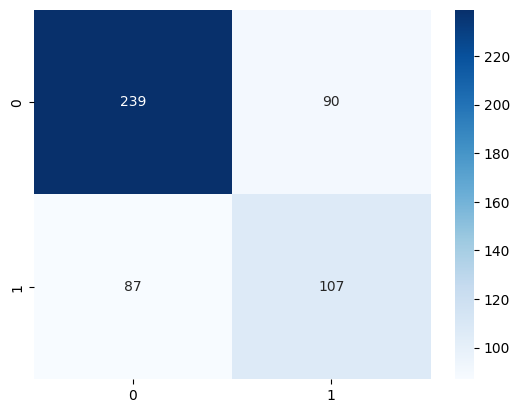

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm_train = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.show()

The model is overtrained

#### XGBClassifier

In [ ]:
from sklearn.metrics import classification_report

# Model definition and training
model = XGBClassifier(random_state=42)
model.fit(X_train, y_train)


# Prediction on train and test data
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# evoluating
report_train = classification_report(y_train, y_pred_train)
report_test = classification_report(y_test, y_pred_test)

print('Train:\n', report_train)
print('\n\nTest:\n', report_test)

Train:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1312
         1.0       1.00      1.00      1.00       792

    accuracy                           1.00      2104
   macro avg       1.00      1.00      1.00      2104
weighted avg       1.00      1.00      1.00      2104



Test:
               precision    recall  f1-score   support

         0.0       0.73      0.80      0.76       345
         1.0       0.54      0.44      0.48       181

    accuracy                           0.68       526
   macro avg       0.63      0.62      0.62       526
weighted avg       0.66      0.68      0.67       526



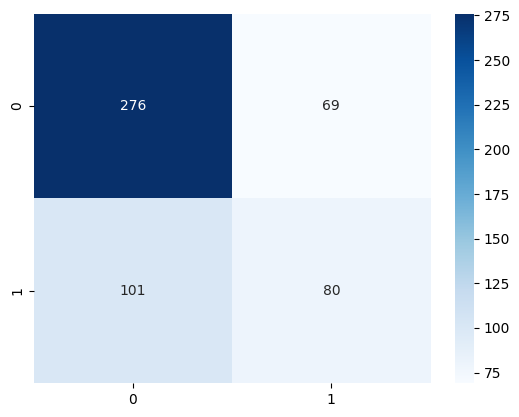

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm_train = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.show()

The model is overtrained

#### Find Hyperparameters (HyperOpt) XGB

In [ ]:
# from hyperopt import fmin, tpe, hp, Trials
# import numpy as np
# from sklearn.model_selection import cross_val_score
# from xgboost import XGBClassifier

# space = {
#     'n_estimators': hp.choice('n_estimators', range(50, 201)),
#     'learning_rate': hp.uniform('learning_rate', 0.001, 0.9),
#     'max_depth': hp.choice('max_depth', range(3, 15)),
#     'min_child_weight': hp.choice('min_child_weight', range(1, 6)),
#     'subsample': hp.uniform('subsample', 0.5, 1.0),
#     'gamma': hp.uniform('gamma', 0, 20),
#     'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
#     'reg_alpha': hp.uniform('reg_alpha', 0, 10),
#     'reg_lambda': hp.uniform('reg_lambda', 0, 10),
# }

# def hyperopt_xgb(params, cv=5, X=X_train, y=y_train):
#     model = XGBClassifier(**params)
#     model.fit(X, y)
#     score = cross_val_score(model, X, y, cv=cv, scoring="accuracy", n_jobs=-1).mean()
#     return -score

# trials = Trials()
# best = fmin(hyperopt_xgb,
#             space=space,
#             algo=tpe.suggest,
#             max_evals=100,
#             trials=trials,
#             rstate=np.random.default_rng(42)
#            )

# print(f"Best hyperparameter values: {best}")

In [ ]:
# from hyperopt import fmin, tpe, hp, Trials
# import numpy as np
# from sklearn.model_selection import cross_val_score
# from xgboost import XGBClassifier

# space = {
#     'n_estimators': hp.choice('n_estimators', range(50, 201)),
#     'learning_rate': hp.uniform('learning_rate', 0.01, 0.5),
#     'max_depth': hp.choice('max_depth', range(4, 15)),
#     'gamma': hp.uniform('gamma', 0, 20),
# }

# def hyperopt_xgb(params, cv=5, X=X_train, y=y_train):
#     model = LGBMClassifier(**params)
#     model.fit(X, y)
#     score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()
#     return -score

# trials = Trials()
# best = fmin(hyperopt_xgb,
#             space=space,
#             algo=tpe.suggest,
#             max_evals=100,
#             trials=trials,
#             rstate=np.random.default_rng(42)
#            )

# print(f"Best hyperparameter values: {best}")

In [ ]:
# # Let's continue to look for the most optimal parameters

# best = fmin(hyperopt_xgb,  # our function
#             space=space,  # hyperparameter space
#             algo=tpe.suggest,  # optimization algorithm, set by default, not required to specify
#             max_evals=300,  # maximum number of iterations
#             trials=trials,  # logging results
#             rstate=np.random.default_rng(42)  # set for result reproducibility
#            )
# print(f"Best hyperparameter values: {best}")

#### Find Hyperparameters (HyperOpt) LGBM

In [ ]:
from hyperopt import fmin, tpe, hp, Trials
import numpy as np
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMClassifier

space = {
    'n_estimators': hp.choice('n_estimators', range(50, 201)),
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.9),
    'max_depth': hp.choice('max_depth', range(3, 15)),
    'min_child_weight': hp.choice('min_child_weight', range(1, 6)),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0, 10),
    'reg_lambda': hp.uniform('reg_lambda', 0, 10),
}

def hyperopt_lgbm(params, cv=5, X=X_train, y=y_train):
    model = LGBMClassifier(class_weight='balanced', verbosity=-1, random_state=42, **params)
    model.fit(X, y)
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()
    return -score

trials = Trials()
best = fmin(hyperopt_lgbm,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials,
            rstate=np.random.default_rng(42)
           )

print(f"Best hyperparameter values: {best}")

 25%|██▌       | 25/100 [01:14<03:43,  2.98s/trial, best loss: -0.5841414789468682]


KeyboardInterrupt: 

In [ ]:
# Let's continue to look for the most optimal parameters

best = fmin(hyperopt_lgbm,  # our function
            space=space,  # hyperparameter space
            algo=tpe.suggest,  # optimization algorithm, set by default, not required to specify
            max_evals=500,  # maximum number of iterations
            trials=trials,  # logging results
            rstate=np.random.default_rng(42)  # set for result reproducibility
           )
print(f"Best hyperparameter values: {best}")

#### Training

In [ ]:
# from xgboost import XGBClassifier

# best_params = {
#     'n_estimators': best['n_estimators'],
#     'learning_rate': best['learning_rate'],
#     'max_depth': best['max_depth'],
#     'gamma': best['gamma'],

# }

# xgb = XGBClassifier(**best_params)

In [ ]:
# from xgboost import XGBClassifier

# best_params = {
#     'n_estimators': best['n_estimators'],
#     'learning_rate': best['learning_rate'],
#     'max_depth': best['max_depth'],
#     'min_child_weight': best['min_child_weight'],
#     'subsample': best['subsample'],
#     'gamma': best['gamma'],
#     'colsample_bytree': best['colsample_bytree'],
#     'reg_alpha': best['reg_alpha'],
#     'reg_lambda': best['reg_lambda']
# }

# xgb = XGBClassifier(**best_params)

In [ ]:
best_params = {
    'n_estimators': best['n_estimators'],
    'learning_rate': best['learning_rate'],
    'max_depth': best['max_depth'],
    'min_child_weight': best['min_child_weight'],
    'subsample': best['subsample'],
    'colsample_bytree': best['colsample_bytree'],
    'reg_alpha': best['reg_alpha'],
    'reg_lambda': best['reg_lambda']
}

lgbm = LGBMClassifier(class_weight='balanced', verbosity=-1, random_state=42, **best_params)

In [ ]:
from sklearn import model_selection

# Performing cross-validation and obtaining predictions for the training set
y_pred_train= model_selection.cross_val_predict(estimator=lgbm, X=X_train, y=y_train, cv=5)

# Performing cross-validation and obtaining predictions for the test set
y_pred_test = model_selection.cross_val_predict(estimator=lgbm, X=X_test, y=y_test, cv=5)


# evoluating
report_train = classification_report(y_train, y_pred_train)
report_test = classification_report(y_test, y_pred_test)

print('Train:\n', report_train)
print('\n\nTest:\n', report_test)

Train:
               precision    recall  f1-score   support

         0.0       0.74      0.73      0.73      1312
         1.0       0.56      0.58      0.57       792

    accuracy                           0.67      2104
   macro avg       0.65      0.65      0.65      2104
weighted avg       0.67      0.67      0.67      2104



Test:
               precision    recall  f1-score   support

         0.0       0.70      0.73      0.72       345
         1.0       0.44      0.41      0.43       181

    accuracy                           0.62       526
   macro avg       0.57      0.57      0.57       526
weighted avg       0.61      0.62      0.62       526



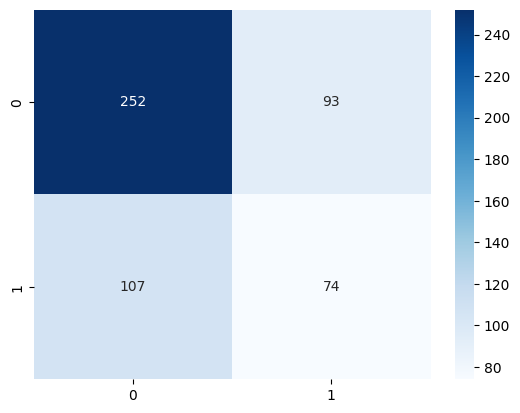

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm_train = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.show()

In [ ]:
lgbm.fit(X_train, y_train)


# Prediction on train and test data
y_pred_train = lgbm.predict(X_train)
y_pred_test = lgbm.predict(X_test)

# evoluating
report_train = classification_report(y_train, y_pred_train)
report_test = classification_report(y_test, y_pred_test)

print('Train:\n', report_train)
print('\n\nTest:\n', report_test)

Train:
               precision    recall  f1-score   support

         0.0       0.98      0.92      0.95      1312
         1.0       0.88      0.96      0.92       792

    accuracy                           0.94      2104
   macro avg       0.93      0.94      0.93      2104
weighted avg       0.94      0.94      0.94      2104



Test:
               precision    recall  f1-score   support

         0.0       0.77      0.70      0.74       345
         1.0       0.52      0.61      0.56       181

    accuracy                           0.67       526
   macro avg       0.65      0.66      0.65       526
weighted avg       0.69      0.67      0.68       526



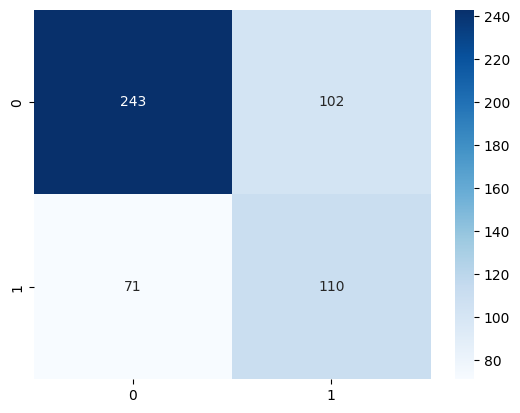

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm_train = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.show()

In [ ]:
import pickle


with open('lgbm_model_full.pkl', 'wb') as f:
    pickle.dump(lgbm, f)

# При необходимости загрузка модели из файла
# with open('lgbm_model.pkl', 'rb') as f:
#     lgbm = pickle.load(f)

### Feature Selection

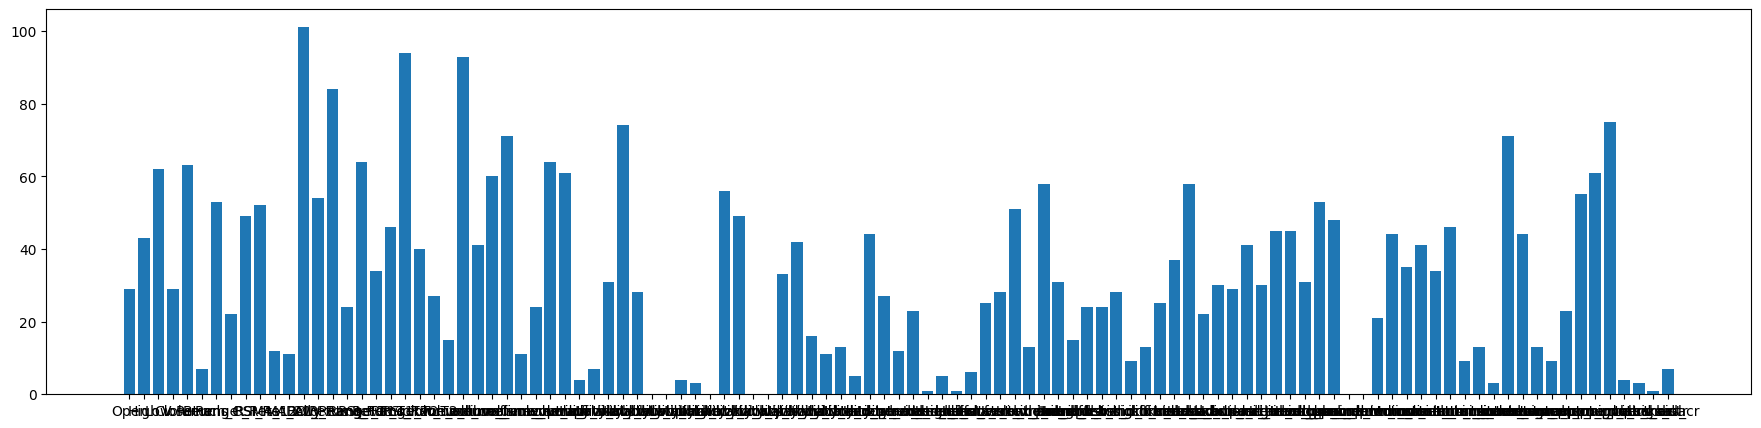

In [ ]:
# Plot Feature Importances
fig = plt.figure(figsize=(22, 5))
importance_labels = X.columns
importance_features = lgbm.feature_importances_
plt.bar(importance_labels, importance_features)
plt.show()

In [ ]:
# Select Best Features
mean_feature_importance = importance_features.mean()
i = 0
recommended_feature_labels = []
recommended_feature_score = []
for fi in importance_features:
    if fi > mean_feature_importance:
        recommended_feature_labels.append(importance_labels[i])
        recommended_feature_score.append(fi)
    i += 1

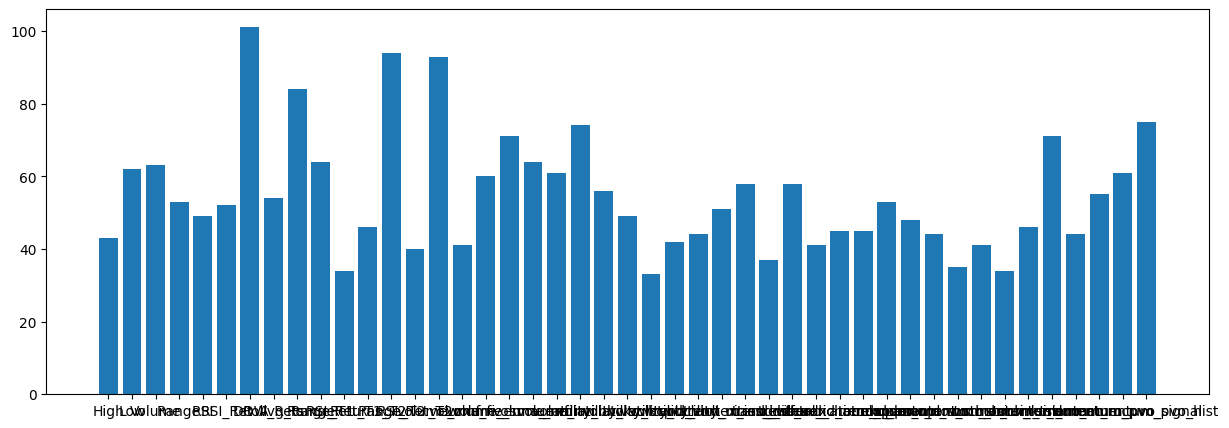

In [ ]:
# Plot Recommended Features
fig = plt.figure(figsize=(15, 5))
plt.bar(recommended_feature_labels, recommended_feature_score)
plt.show()

In [ ]:
recommended_feature_labels

['High',
 'Low',
 'Volume',
 'Range',
 'RSI',
 'RSI_Ret',
 'DOW',
 'Roll_Rets',
 'Avg_Range',
 'Range_T1',
 'RSI_Ret_T1',
 'Returns_T2',
 'Range_T2',
 'RSI_Ret_T2',
 'volume_cmf',
 'volume_fi',
 'volume_em',
 'volume_sma_em',
 'volume_mfi',
 'volume_nvi',
 'volatility_bbw',
 'volatility_kcw',
 'volatility_kcp',
 'volatility_dcl',
 'volatility_dch',
 'volatility_ui',
 'trend_vortex_ind_diff',
 'trend_mass_index',
 'trend_stc',
 'trend_adx',
 'trend_visual_ichimoku_a',
 'trend_aroon_up',
 'trend_aroon_down',
 'trend_psar_up',
 'trend_psar_down',
 'momentum_stoch_rsi',
 'momentum_stoch_rsi_k',
 'momentum_stoch_rsi_d',
 'momentum_tsi',
 'momentum_uo',
 'momentum_ao',
 'momentum_roc',
 'momentum_pvo',
 'momentum_pvo_signal',
 'momentum_pvo_hist']

### Fearure Selection Training

#### Train Test Split

In [ ]:
# Feature Selection
df_tts = df.copy()
df_tts = df_tts[recommended_feature_labels + ["TARGET"]]

In [ ]:
df_tts.head()

,High,Low,Volume,Range,RSI,RSI_Ret,DOW,Roll_Rets,Avg_Range,Range_T1,...,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,momentum_uo,momentum_ao,momentum_roc,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,TARGET
Date,,,,,,,,,,,,,,,,,,,,,
2017-02-01,0.017587,0.054056,-0.087932,0.018926,63.109498,1.048237,2,0.007132,0.057381,0.055442,...,0.0,0.0,100.000000,101.909664,0.000000,0.0,-9.361307,-1.872261,-7.489045,0.0
2017-02-02,0.024675,0.012855,-0.028572,0.030816,66.345006,1.051268,3,0.008542,0.057675,0.018926,...,0.0,0.0,100.000000,102.108200,0.000000,0.0,-17.451835,-4.988176,-12.463659,0.0
2017-02-03,0.020079,0.026005,0.380309,0.024861,68.695922,1.035435,4,-0.079792,0.054832,0.030816,...,0.0,0.0,100.000000,101.999618,0.000000,0.0,-20.409765,-8.072494,-12.337271,0.0
2017-02-04,0.011636,0.006314,-0.229603,0.030281,70.298572,1.023330,5,0.055230,0.045565,0.024861,...,0.0,0.0,100.000000,101.809568,0.000000,0.0,-30.088366,-12.475668,-17.612698,0.0
2017-02-05,-0.002170,0.007102,-0.263478,0.020795,65.943485,0.938049,6,0.150021,0.040117,0.030281,...,0.0,0.0,98.160605,101.126754,-0.001587,0.0,-39.936739,-17.967882,-21.968856,0.0


In [ ]:
# Split into Learning (X) and Target (y) Data
X = df_tts.drop('TARGET', axis=1)
y = df_tts['TARGET']

In [ ]:
# Perform Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True)

size_check = len(y_test) + len(y_train) == len(X)
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)
print("Size Matches: ", size_check)

Shape of X_train:  (1972, 45)
Shape of y_train:  (1972,)
Shape of X_test:  (658, 45)
Shape of y_test:  (658,)
Size Matches:  True


#### Find Hyperparameters (HyperOpt)

In [ ]:
from hyperopt import fmin, tpe, hp, Trials
import numpy as np
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMClassifier

space = {
    'n_estimators': hp.choice('n_estimators', range(50, 201)),
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.9),
    'max_depth': hp.choice('max_depth', range(3, 15)),
    'min_child_weight': hp.choice('min_child_weight', range(1, 6)),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0, 10),
    'reg_lambda': hp.uniform('reg_lambda', 0, 10),
}

def hyperopt_lgbm(params, cv=5, X=X_train, y=y_train):
    model = LGBMClassifier(class_weight='balanced', verbosity=-1, random_state=42, **params)
    model.fit(X, y)
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()
    return -score

trials = Trials()
best = fmin(hyperopt_lgbm,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials,
            rstate=np.random.default_rng(42)
           )

print(f"Best hyperparameter values: {best}")

100%|██████████| 100/100 [02:04<00:00,  1.24s/trial, best loss: -0.598669060560867]
Best hyperparameter values: {'colsample_bytree': 0.5006792836303109, 'learning_rate': 0.3316786733971431, 'max_depth': 0, 'min_child_weight': 0, 'n_estimators': 105, 'reg_alpha': 9.553010328699914, 'reg_lambda': 6.821531938133704, 'subsample': 0.983799032737926}


In [ ]:
# Let's continue to look for the most optimal parameters

best = fmin(hyperopt_lgbm,  # our function
            space=space,  # hyperparameter space
            algo=tpe.suggest,  # optimization algorithm, set by default, not required to specify
            max_evals=1000,  # maximum number of iterations
            trials=trials,  # logging results
            rstate=np.random.default_rng(42)  # set for result reproducibility
           )
print(f"Best hyperparameter values: {best}")

100%|██████████| 1000/1000 [05:06<00:00,  1.53s/trial, best loss: -0.6123618817744823]
Best hyperparameter values: {'colsample_bytree': 0.9078598022536107, 'learning_rate': 0.052523455635080166, 'max_depth': 0, 'min_child_weight': 1, 'n_estimators': 142, 'reg_alpha': 7.134775390889469, 'reg_lambda': 2.978681683997359, 'subsample': 0.5486061188736039}


In [ ]:
# from hyperopt import fmin, tpe, hp, Trials
# import numpy as np
# from sklearn.model_selection import cross_val_score
# from xgboost import XGBClassifier

# space = {
#     'n_estimators': hp.choice('n_estimators', range(50, 201)),
#     'learning_rate': hp.uniform('learning_rate', 0.001, 0.9),
#     'max_depth': hp.choice('max_depth', range(3, 15)),
#     'min_child_weight': hp.choice('min_child_weight', range(1, 6)),
#     'subsample': hp.uniform('subsample', 0.5, 1.0),
#     'gamma': hp.uniform('gamma', 0, 20),
#     'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
#     'reg_alpha': hp.uniform('reg_alpha', 0, 10),
#     'reg_lambda': hp.uniform('reg_lambda', 0, 10),
# }

# def hyperopt_xgb(params, cv=5, X=X_train, y=y_train):
#     model = XGBClassifier(**params)
#     model.fit(X, y)
#     score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()
#     return -score

# trials = Trials()
# best = fmin(hyperopt_xgb,
#             space=space,
#             algo=tpe.suggest,
#             max_evals=100,
#             trials=trials,
#             rstate=np.random.default_rng(42)
#            )

# print(f"Best hyperparameter values: {best}")

In [ ]:
# from hyperopt import fmin, tpe, hp, Trials
# import numpy as np
# from sklearn.model_selection import cross_val_score
# from xgboost import XGBClassifier

# space = {
#     'n_estimators': hp.choice('n_estimators', range(50, 201)),
#     'learning_rate': hp.uniform('learning_rate', 0.01, 0.5),
#     'max_depth': hp.choice('max_depth', range(4, 15)),
#     'gamma': hp.uniform('gamma', 0, 20),
# }

# def hyperopt_xgb(params, cv=5, X=X_train, y=y_train):
#     model = XGBClassifier(**params)
#     model.fit(X, y)
#     score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()
#     return -score

# trials = Trials()
# best = fmin(hyperopt_xgb,
#             space=space,
#             algo=tpe.suggest,
#             max_evals=100,
#             trials=trials,
#             rstate=np.random.default_rng(42)
#            )

# print(f"Best hyperparameter values: {best}")

In [ ]:
# # Let's continue to look for the most optimal parameters

# best = fmin(hyperopt_xgb,  # our function
#             space=space,  # hyperparameter space
#             algo=tpe.suggest,  # optimization algorithm, set by default, not required to specify
#             max_evals=300,  # maximum number of iterations
#             trials=trials,  # logging results
#             rstate=np.random.default_rng(42)  # set for result reproducibility
#            )
# print(f"Best hyperparameter values: {best}")

#### Training

In [ ]:
best_params = {
    'n_estimators': best['n_estimators'],
    'learning_rate': best['learning_rate'],
    'max_depth': best['max_depth'],
    'min_child_weight': best['min_child_weight'],
    'subsample': best['subsample'],
    'colsample_bytree': best['colsample_bytree'],
    'reg_alpha': best['reg_alpha'],
    'reg_lambda': best['reg_lambda']
}

lgbm = LGBMClassifier(class_weight='balanced', verbosity=-1, random_state=42, **best_params)

In [ ]:
# from xgboost import XGBClassifier

# best_params = {
#     'n_estimators': best['n_estimators'],
#     'learning_rate': best['learning_rate'],
#     'max_depth': best['max_depth'],
#     'min_child_weight': best['min_child_weight'],
#     'subsample': best['subsample'],
#     'gamma': best['gamma'],
#     'colsample_bytree': best['colsample_bytree'],
#     'reg_alpha': best['reg_alpha'],
#     'reg_lambda': best['reg_lambda']
# }

# xgb = XGBClassifier(**best_params)

In [ ]:
# from xgboost import XGBClassifier

# best_params = {
#     'n_estimators': best['n_estimators'],
#     'learning_rate': best['learning_rate'],
#     'max_depth': best['max_depth'],
#     'gamma': best['gamma'],

# }

# xgb_s = XGBClassifier(**best_params)

In [ ]:
from sklearn import model_selection

# Performing cross-validation and obtaining predictions for the training set
y_pred_train= model_selection.cross_val_predict(estimator=lgbm, X=X_train, y=y_train, cv=5)

# Performing cross-validation and obtaining predictions for the test set
y_pred_test = model_selection.cross_val_predict(estimator=lgbm, X=X_test, y=y_test, cv=5)


# evoluating
report_train = classification_report(y_train, y_pred_train)
report_test = classification_report(y_test, y_pred_test)

print('Train:\n', report_train)
print('\n\nTest:\n', report_test)

Train:
               precision    recall  f1-score   support

         0.0       0.75      0.74      0.74      1231
         1.0       0.58      0.60      0.59       741

    accuracy                           0.68      1972
   macro avg       0.67      0.67      0.67      1972
weighted avg       0.69      0.68      0.69      1972



Test:
               precision    recall  f1-score   support

         0.0       0.74      0.71      0.73       426
         1.0       0.51      0.55      0.53       232

    accuracy                           0.66       658
   macro avg       0.63      0.63      0.63       658
weighted avg       0.66      0.66      0.66       658



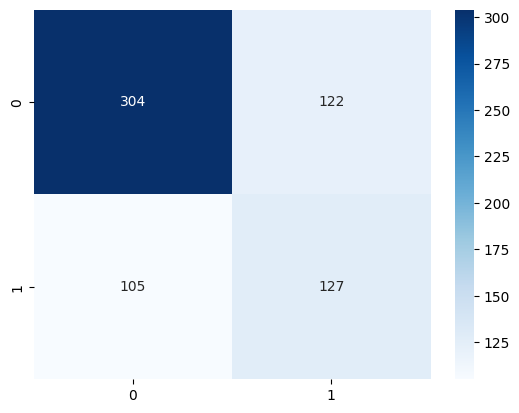

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm_train = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.show()

In [ ]:
# from sklearn import model_selection
# from sklearn.metrics import classification_report

# # Performing cross-validation and obtaining predictions for the training set
# y_pred_train= model_selection.cross_val_predict(estimator=xgb, X=X_train, y=y_train, cv=5)

# # Performing cross-validation and obtaining predictions for the test set
# y_pred_test = model_selection.cross_val_predict(estimator=xgb, X=X_test, y=y_test, cv=5)


# # evoluating
# report_train = classification_report(y_train, y_pred_train)
# report_test = classification_report(y_test, y_pred_test)

# print('Train:\n', report_train)
# print('\n\nTest:\n', report_test)

In [ ]:
eval_set = [(X_train, y_train), (X_test, y_test)]
lgbm.fit(X_train, y_train, eval_set=eval_set, eval_metric='logloss')


# Prediction on train and test data
y_pred_train = lgbm.predict(X_train)
y_pred_test = lgbm.predict(X_test)

# evoluating
report_train = classification_report(y_train, y_pred_train)
report_test = classification_report(y_test, y_pred_test)

print('Train:\n', report_train)
print('\n\nTest:\n', report_test)

Train:
               precision    recall  f1-score   support

         0.0       0.97      0.91      0.94      1231
         1.0       0.86      0.95      0.90       741

    accuracy                           0.92      1972
   macro avg       0.91      0.93      0.92      1972
weighted avg       0.93      0.92      0.92      1972



Test:
               precision    recall  f1-score   support

         0.0       0.76      0.70      0.73       426
         1.0       0.52      0.59      0.55       232

    accuracy                           0.66       658
   macro avg       0.64      0.65      0.64       658
weighted avg       0.68      0.66      0.67       658



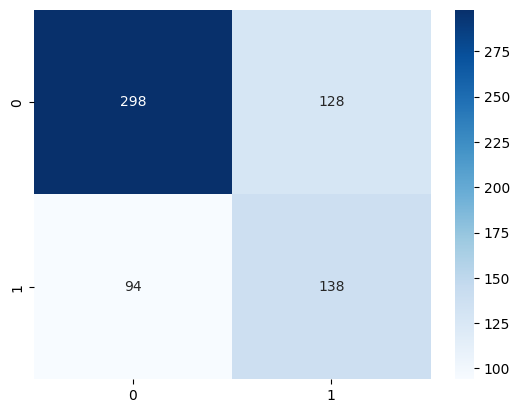

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm_train = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.show()

In [ ]:
# xgb.fit(X_train, y_train)


# # Prediction on train and test data
# y_pred_train = xgb.predict(X_train)
# y_pred_test = xgb.predict(X_test)

# # evoluating
# report_train = classification_report(y_train, y_pred_train)
# report_test = classification_report(y_test, y_pred_test)

# print('Train:\n', report_train)
# print('\n\nTest:\n', report_test)

### Evaluation Metrics  - Loss and Overfitting

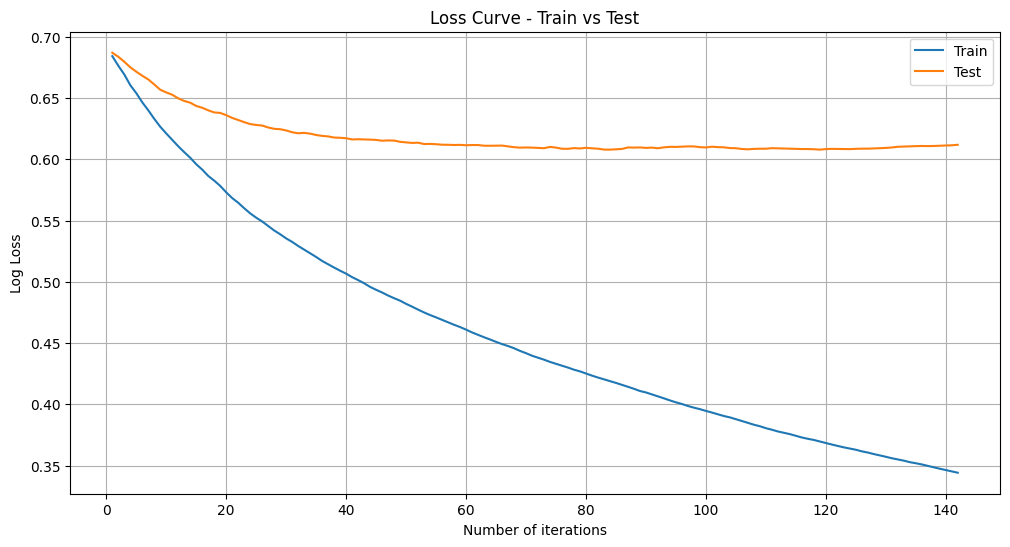

In [ ]:
import matplotlib.pyplot as plt

# Get the loss values for train and test data
loss_train = lgbm.evals_result_['training']['binary_logloss']
loss_test = lgbm.evals_result_['valid_1']['binary_logloss']

# Plot the loss curves
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(loss_train) + 1), loss_train, label='Train')
plt.plot(range(1, len(loss_test) + 1), loss_test, label='Test')
plt.xlabel('Number of iterations')
plt.ylabel('Log Loss')
plt.title('Loss Curve - Train vs Test')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import pickle

# Save the mocel
with open('lgbm_model_l.pkl', 'wb') as f:
    pickle.dump(lgbm, f)

#Load the modal
# with open('lgbm_model.pkl', 'rb') as f:
#     lgbm = pickle.load(f)

In [ ]:
import joblib


joblib.dump(lgbm, 'lgbm_model.pkl')

# lgbm = joblib.load('lgbm_model.pkl')

['lgbm_model.pkl']

In [ ]:
df.tail(20)

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Ret,...,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr,TARGET
Date,,,,,,,,,,,,,,,,,,,,,
2024-03-26,0.040117,0.005244,0.043978,0.000415,-0.156667,0.000415,0.031732,0.000479,59.005994,1.000689,...,3.938247,-0.840357,-47.063944,-68.928983,21.865039,67061.841843,0.041486,0.041478,7112.244278,0.0
2024-03-27,0.000866,0.002683,-0.013755,-0.007608,0.133758,-0.007608,0.048928,-0.007740,57.874623,0.980826,...,3.774096,-0.656603,-28.053209,-60.753828,32.700619,67082.085905,-0.760835,-0.763744,7057.370975,0.0
2024-03-28,-0.007703,-0.002533,0.007510,0.018567,-0.158037,0.018567,0.038472,0.018797,59.880894,1.034666,...,3.668621,-0.421900,-67.286658,-62.060394,-5.226264,67159.497507,1.856746,1.839719,7190.265181,0.0
2024-03-29,0.018603,-0.008846,0.002629,-0.012045,-0.266009,-0.012045,0.026586,-0.012184,57.918033,0.967221,...,3.576483,-0.368551,-200.488805,-89.746076,-110.742729,67434.456614,-1.204503,-1.211816,7102.453726,0.0
2024-03-30,-0.012034,-0.007863,0.007592,-0.003541,-0.321060,-0.003541,0.010839,-0.003550,57.330162,0.989850,...,3.483299,-0.372733,-6683.638538,-1408.524569,-5275.113970,67479.740511,-0.354147,-0.354776,7076.946444,0.0
2024-03-31,-0.003515,0.014530,0.000342,0.024242,0.170500,0.024242,0.025177,0.024542,60.290822,1.051642,...,3.425372,-0.231711,-355.732624,-1197.966180,842.233556,67939.078472,2.424203,2.395286,7250.930214,0.0
2024-04-01,0.024203,-0.000500,-0.021748,-0.022871,0.739246,-0.022871,0.047443,-0.023109,56.230588,0.932656,...,3.346543,-0.315314,24.941177,-953.384708,978.325885,68156.276036,-2.287139,-2.313700,7082.804191,1.0
2024-04-02,-0.022829,-0.022900,-0.051741,-0.061048,0.453975,-0.061048,0.079301,-0.061812,47.286223,0.840934,...,3.152329,-0.776857,46.924384,-753.322890,800.247274,68120.264150,-6.104799,-6.299090,6644.308461,0.0
2024-04-03,-0.061091,-0.040082,-0.000413,0.008157,-0.319833,0.008157,0.036469,0.008186,48.395257,1.023454,...,2.901063,-1.005064,7.596037,-601.139104,608.735142,68089.830897,0.815683,0.812374,6699.320640,1.0


In [ ]:
df['Close'].iloc[-1]

0.0300408910426832

In [ ]:
df["TARGET"].iloc[-1]

0.0

In [ ]:
#df_tts = df_tts[recommended_feature_labels + ["TARGET"]]

In [ ]:
recommended_feature_labels = ['High',
 'Low',
 'Volume',
 'Range',
 'RSI',
 'RSI_Ret',
 'DOW',
 'Roll_Rets',
 'Avg_Range',
 'Range_T1',
 'RSI_Ret_T1',
 'Returns_T2',
 'Range_T2',
 'RSI_Ret_T2',
 'volume_cmf',
 'volume_fi',
 'volume_em',
 'volume_sma_em',
 'volume_mfi',
 'volume_nvi',
 'volatility_bbw',
 'volatility_kcw',
 'volatility_kcp',
 'volatility_dcl',
 'volatility_dch',
 'volatility_ui',
 'trend_vortex_ind_diff',
 'trend_mass_index',
 'trend_stc',
 'trend_adx',
 'trend_visual_ichimoku_a',
 'trend_aroon_up',
 'trend_aroon_down',
 'trend_psar_up',
 'trend_psar_down',
 'momentum_stoch_rsi',
 'momentum_stoch_rsi_k',
 'momentum_stoch_rsi_d',
 'momentum_tsi',
 'momentum_uo',
 'momentum_ao',
 'momentum_roc',
 'momentum_pvo',
 'momentum_pvo_signal',
 'momentum_pvo_hist']

### Prediction

#### All Features

In [ ]:
#!pip install ta

import yfinance as yf
import numpy as np
import pandas as pd
from ta import add_all_ta_features
from ta.momentum import RSIIndicator
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
import joblib


class DataExtraction():
    # Initialize the class
    def __init__(self, symbol, start_date, end_date):
        self.df = self._extract_data(symbol, start_date, end_date)
        self.sharpe = 0

    # Extract data
    def _extract_data(self, symbol, start_date, end_date):
        from pandas_datareader.data import DataReader
        data = yf.download(symbol, start_date, end_date)
        #data = DataReader(name=symbol, data_source='yahoo', start=start_date, end=end_date)
        data = data[["Open", "High", "Low", "Close", "Volume"]]
        data = self._structure_df(data)
        return data

    # Calculates general period returns and volatility
    def _structure_df(self, df):
        df["Returns"] = df["Close"].pct_change()
        df["Range"] = df["High"] / df["Low"] - 1
        df["Bench_C_Rets"], sharpe = self._calculate_returns(df, True)
        self.sharpe = sharpe
        df.dropna(inplace=True)
        return df

    # Adjusts the signal to represent our strategy
    def _set_multiplier(self, direction):
        if direction == "long":
            pos_multiplier = 1
            neg_multiplier = 0
        elif direction == "long_short":
            pos_multiplier = 1
            neg_multiplier = -1
        else:
            pos_multiplier = 0
            neg_multiplier = -1
        return pos_multiplier, neg_multiplier

    # Calculates returns for equity curve
    def _calculate_returns(self, df, is_benchmark):

        # Calculate multiplier
        if not is_benchmark:
            multiplier_1 = df["Signal"]
            multiplier_2 = 1 if "PSignal" not in df.columns else df["PSignal"]
            log_rets = np.log(df["Close"] / df["Close"].shift(1)) * multiplier_1 * multiplier_2
        else:
            multiplier_1 = 1
            multiplier_2 = 1

            # Assume open price on following day to avoid lookahead bias for close calculation
            log_rets = np.log(df["Open"].shift(-1) / df["Close"].shift(1)) * multiplier_1 * multiplier_2

        # Calculate Sharpe Ratio
        sharpe_ratio = self.sharpe_ratio(log_rets)

        # Calculate Cumulative Returns
        c_log_rets = log_rets.cumsum()
        c_log_rets_exp = np.exp(c_log_rets) - 1

        # Return result and Sharpe ratio
        return c_log_rets_exp, sharpe_ratio

    def sharpe_ratio(self, return_series):
        N = 255 # Trading days in the year (change to 365 for crypto)
        rf = 0.005 # Half a percent risk free rare
        mean = return_series.mean() * N -rf
        sigma = return_series.std() * np.sqrt(N)
        sharpe = round(mean / sigma, 3)
        return sharpe

    # Replace Dataframe
    def change_df(self, new_df, drop_cols=[]):
        new_df = new_df.drop(columns=drop_cols)
        self.df = new_df

    # Moving average crossover strategy
    def backtest_ma_crossover(self, period_1, period_2, direction, drop_cols=[]):

        # Set df
        df = self.df

        # Get multipliers
        pos_multiplier, neg_multiplier = self._set_multiplier(direction)

        # Calculate Moving Averages
        if f"MA_{period_1}" or f"MA_{period_2}" not in df.columns:
            df[f"MA_{period_1}"] = df["Close"].rolling(window=period_1).mean()
            df[f"MA_{period_2}"] = df["Close"].rolling(window=period_2).mean()
            df.dropna(inplace=True)

        # Calculate Benchmark Returns
        df["Bench_C_Rets"], sharpe_ratio_bench = self._calculate_returns(df, True)

        # Calculate Signal
        df.loc[df[f"MA_{period_1}"] > df[f"MA_{period_2}"], "Signal"] = pos_multiplier
        df.loc[df[f"MA_{period_1}"] <= df[f"MA_{period_2}"], "Signal"] = neg_multiplier

        # Calculate Strategy Returns
        df["Strat_C_Rets"], sharpe_ratio_strat = self._calculate_returns(df, False)

        # Get values for output
        bench_rets = df["Bench_C_Rets"].values.astype(float)
        strat_rets = df["Strat_C_Rets"].values.astype(float)
        print("Sense check: ", round(df["Close"].values[-1] / df["Close"].values[0] - 1, 3), round(bench_rets[-1], 3))

        # Remove irrelevant features
        if len(drop_cols) > 0:
            df = df.drop(columns=drop_cols)

        # Ensure Latest DF matches
        df = df.dropna()
        self.df = df

        # Return df
        return df, sharpe_ratio_bench, sharpe_ratio_strat


class Model():
    def __init__(self, model_path):
        self.model = self.load_model(model_path)

    def load_model(self, model_path):
        return joblib.load(model_path)

    def predict_tomorrow(self, X):
        prediction = self.model.predict(X)[-1]
        return "Price will fall or won't change" if prediction == 0 else "Price will not fall or increase"

start_date = "2023-01-30"
end_date = "2024-04-18"
symbol = "BTC-USD"
data = DataExtraction(symbol, start_date, end_date)
df = data.df.copy()

model_path = "lgbm_model_full.pkl"
model = Model(model_path)

df_fe = df.copy()

rsi = RSIIndicator(close=df_fe["Close"], window=14).rsi()
df_fe["RSI"] = rsi
df_fe["RSI_Ret"] = df_fe["RSI"] / df_fe["RSI"].shift(1)

# Add Moving Average
df_fe["MA_12"] = df_fe["Close"].rolling(window=12).mean()
df_fe["MA_21"] = df_fe["Close"].rolling(window=21).mean()

df_fe["DOW"] = df_fe.index.dayofweek

# Rolling Cumulative Returns
df_fe["Roll_Rets"] = df_fe["Returns"].rolling(window=30).sum()

# Rolling Cumulative Range
df_fe["Avg_Range"] = df_fe["Range"].rolling(window=30).mean()

# Add Time Intervals
t_steps = [1, 2]
t_features = ["Returns", "Range", "RSI_Ret"]
for ts in t_steps:
    for tf in t_features:
        df_fe[f"{tf}_T{ts}"] = df_fe[tf].shift(ts)

df_fe.dropna(inplace=True)

# Concatenate DataFrame once instead of inserting columns multiple times
df_fe = add_all_ta_features(df_fe, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)

# Identify non-stationary columns
non_stationaries = []

for col in df_fe.columns:
    if df_fe[col].nunique() > 1:
        dftest = adfuller(df_fe[col].values)
        p_value = dftest[1]
        t_test = dftest[0] < dftest[4]["1%"]
        if p_value > 0.05 or not t_test:
            non_stationaries.append(col)

df_fe[non_stationaries] = df_fe[non_stationaries].pct_change()
df_fe.dropna(inplace=True)

# Prediction
X = df_fe

# Get the last date from DataFrame
last_date = df.index[-1]

# Add one day to the last date
tomorrow_date = last_date + pd.Timedelta(days=1)

# Convert the date to the required format (if needed)
tomorrow_date_str = tomorrow_date.strftime("%Y-%m-%d")

# Print the date
print("Prediction for", tomorrow_date_str)

# Predict tomorrow's price
prediction = model.predict_tomorrow(X[-1:])
print(f"Prediction for tomorrow ({tomorrow_date_str}): {prediction}")

[*********************100%%**********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/ta/wrapper.py:536: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{colprefix}others_cr"] = CumulativeReturnIndicator(


Prediction for 2024-04-16
Prediction for tomorrow (2024-04-16): Price will not fall or increase


#### Selected Features

In [ ]:
#!pip install ta

import yfinance as yf
import numpy as np
import pandas as pd
from ta import add_all_ta_features
from ta.momentum import RSIIndicator
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
import joblib


# List of selected features
selected_features = [
        'High', 'Low', 'Volume', 'Range', 'RSI', 'RSI_Ret', 'DOW', 'Roll_Rets', 'Avg_Range',
        'Range_T1', 'RSI_Ret_T1', 'Returns_T2', 'Range_T2', 'RSI_Ret_T2', 'volume_cmf', 'volume_fi',
        'volume_em', 'volume_sma_em', 'volume_mfi', 'volume_nvi', 'volatility_bbw', 'volatility_kcw',
        'volatility_kcp', 'volatility_dcl', 'volatility_dch', 'volatility_ui', 'trend_vortex_ind_diff',
        'trend_mass_index', 'trend_stc', 'trend_adx', 'trend_visual_ichimoku_a', 'trend_aroon_up',
        'trend_aroon_down', 'trend_psar_up', 'trend_psar_down', 'momentum_stoch_rsi', 'momentum_stoch_rsi_k',
        'momentum_stoch_rsi_d', 'momentum_tsi', 'momentum_uo', 'momentum_ao', 'momentum_roc', 'momentum_pvo',
        'momentum_pvo_signal', 'momentum_pvo_hist'
    ]

class DataExtraction():
    def __init__(self, symbol, start_date, end_date):
        self.df = self._extract_data(symbol, start_date, end_date)
        self.sharpe = 0

    def _extract_data(self, symbol, start_date, end_date):
        data = yf.download(symbol, start_date, end_date)
        data = data[["Open", "High", "Low", "Close", "Volume"]]
        data = self._structure_df(data)
        return data

    def _structure_df(self, df):
        df["Returns"] = df["Close"].pct_change()
        df["Range"] = df["High"] / df["Low"] - 1
        df.dropna(inplace=True)
        return df

    def change_df(self, new_df, drop_cols=[]):
        new_df = new_df.drop(columns=drop_cols)
        self.df = new_df

class Model():
    def __init__(self, model_path):
        self.model = self.load_model(model_path)

    def load_model(self, model_path):
        return joblib.load(model_path)

    def predict_tomorrow(self, X):
        prediction = self.model.predict(X)[-1]
        return "Price will fall or won't change" if prediction == 0 else "Price will not fall or increase"

start_date = "2023-01-30"
end_date = "2024-04-18"
symbol = "BTC-USD"
data = DataExtraction(symbol, start_date, end_date)
df = data.df.copy()

model_path = "lgbm_model_l.pkl"
model = Model(model_path)

df_fe = df.copy()

rsi = RSIIndicator(close=df_fe["Close"], window=14).rsi()
df_fe["RSI"] = rsi
df_fe["RSI_Ret"] = df_fe["RSI"] / df_fe["RSI"].shift(1)

# Add Moving Average
df_fe["MA_12"] = df_fe["Close"].rolling(window=12).mean()
df_fe["MA_21"] = df_fe["Close"].rolling(window=21).mean()

df_fe["DOW"] = df_fe.index.dayofweek

# Rolling Cumulative Returns
df_fe["Roll_Rets"] = df_fe["Returns"].rolling(window=30).sum()

# Rolling Cumulative Range
df_fe["Avg_Range"] = df_fe["Range"].rolling(window=30).mean()

# Add Time Intervals
t_steps = [1, 2]
t_features = ["Returns", "Range", "RSI_Ret"]
for ts in t_steps:
    for tf in t_features:
        df_fe[f"{tf}_T{ts}"] = df_fe[tf].shift(ts)

df_fe.dropna(inplace=True)

# Concatenate DataFrame once instead of inserting columns multiple times
df_fe = add_all_ta_features(df_fe, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)

# Identify non-stationary columns
non_stationaries = []

for col in df_fe.columns:
    if df_fe[col].nunique() > 1:
        dftest = adfuller(df_fe[col].values)
        p_value = dftest[1]
        t_test = dftest[0] < dftest[4]["1%"]
        if p_value > 0.05 or not t_test:
            non_stationaries.append(col)

df_fe[non_stationaries] = df_fe[non_stationaries].pct_change()
df_fe.dropna(inplace=True)

# Prediction
X = df_fe[selected_features]

# Get the last date from DataFrame
last_date = df.index[-1]

# Add one day to the last date
tomorrow_date = last_date + pd.Timedelta(days=1)

# Convert the date to the required format (if needed)
tomorrow_date_str = tomorrow_date.strftime("%Y-%m-%d")

# Print the date
print("Prediction for", tomorrow_date_str)

# Predict tomorrow's price
prediction = model.predict_tomorrow(X[-1:])
print(f"Prediction for tomorrow ({tomorrow_date_str}): {prediction}")

[*********************100%%**********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/ta/wrapper.py:536: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{colprefix}others_cr"] = CumulativeReturnIndicator(


Prediction for 2024-04-18
Prediction for tomorrow (2024-04-18): Price will not fall or increase


# Bitcoin Price Prediction Model-2

In [ ]:
!pip install tensorflow

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, log_loss
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import tensorflow as tf

In [ ]:
# Data Extraction
start_date = "2014-09-17"
end_date = "2024-04-17"
symbol = "BTC-USD"
data = yf.download(symbol, start_date, end_date)
data.reset_index(inplace=True)

[*********************100%%**********************]  1 of 1 completed


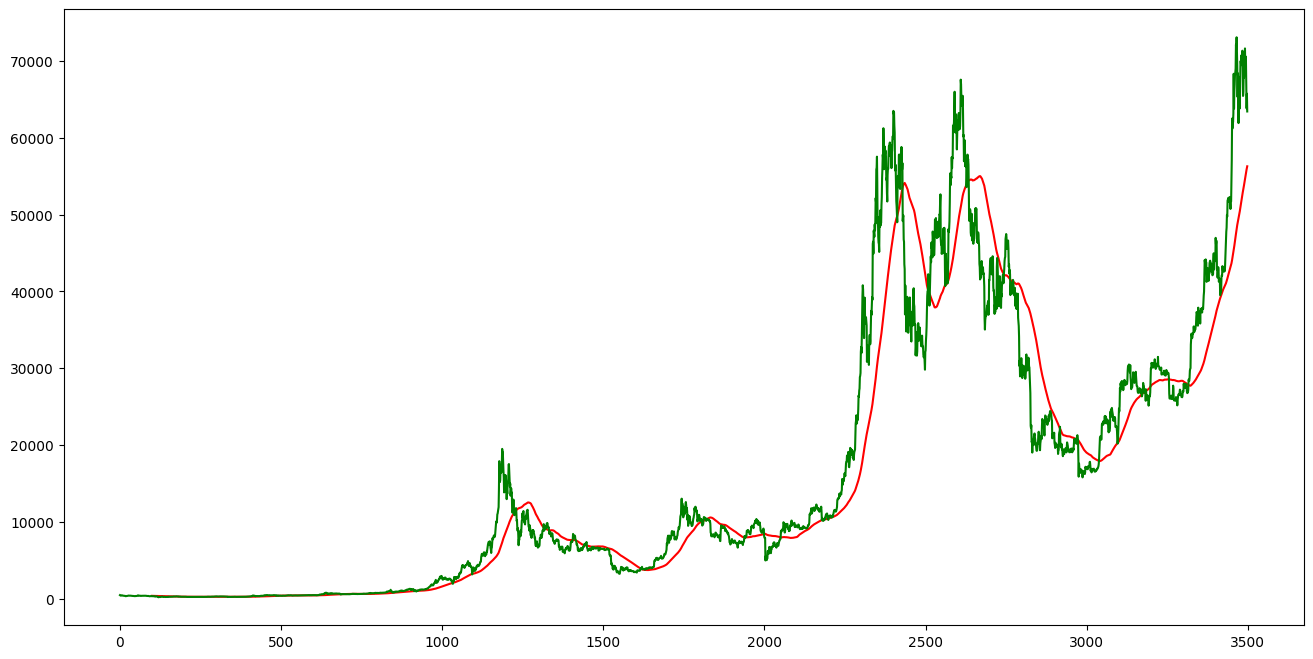

In [ ]:
# Creation of moving averages
data['ma_100_days'] = data['Close'].rolling(100).mean()
plt.figure(figsize=(16,8))
plt.plot(data['ma_100_days'], 'r')
plt.plot(data['Close'], 'g')
plt.show()

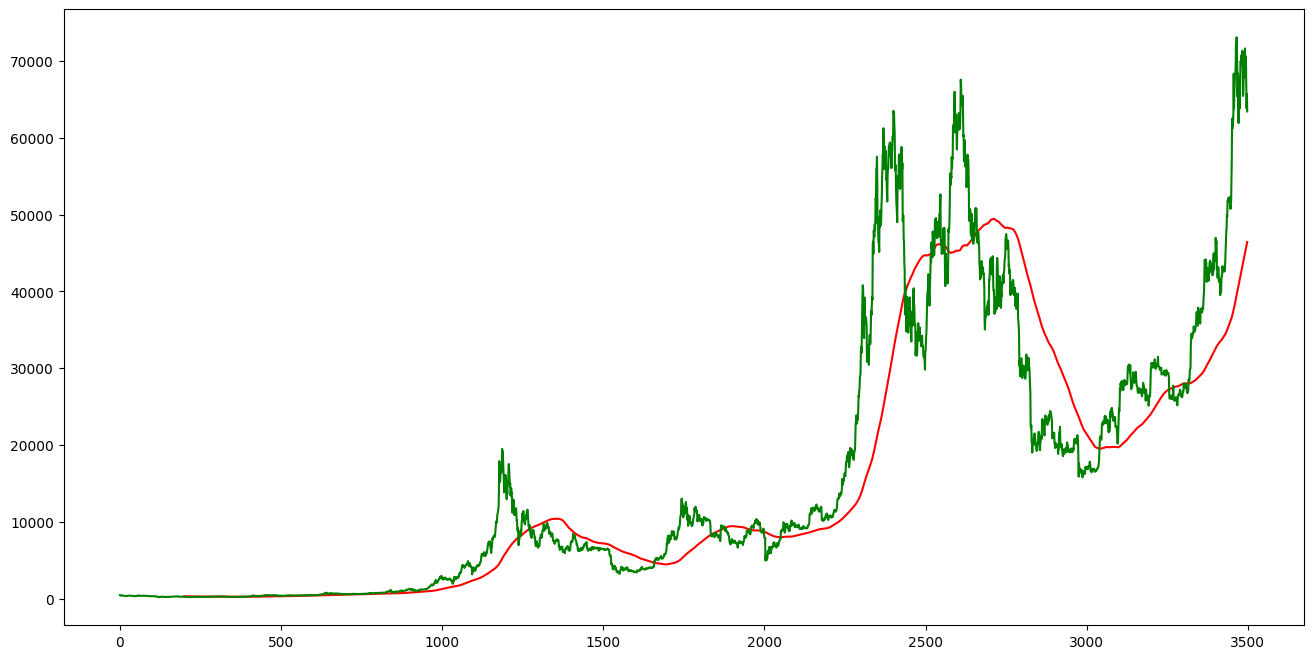

In [ ]:
data['ma_200_days'] = data['Close'].rolling(200).mean()
plt.figure(figsize=(16,8))
plt.plot(data['ma_200_days'], 'r')
plt.plot(data['Close'], 'g')
plt.show()

In [ ]:
data.dropna(inplace=True)

In [ ]:
# Dividing data into training and test sets
data_train = pd.DataFrame(data['Close'][0: int(len(data) * 0.8)])
data_test = pd.DataFrame(data['Close'][int(len(data) * 0.8): len(data)])

print(data_train.shape, data_test.shape, sep='\n')

(2640, 1)
(660, 1)


In [ ]:
# Data Scaling
scaler = MinMaxScaler(feature_range=(0,1))
data_train_scale = scaler.fit_transform(data_train)

In [ ]:
x = []
y = []
window_size = 100

for i in range(window_size, data_train_scale.shape[0]):
    x.append(data_train_scale[i - 100:i])
    y.append(data_train_scale[i, 0])

x, y = np.array(x), np.array(y)

In [ ]:
# Model creation and compilation
model = Sequential()
model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(x.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=60, activation='relu', return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=80, activation='relu', return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(units=120, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [12]:
# Training
model.fit(x, y, epochs=50, batch_size=32)

Epoch 1/50
80/80 [==============================] - 32s 402ms/step - loss: 0.0023
Epoch 2/50
80/80 [==============================] - 21s 257ms/step - loss: 0.0021
Epoch 3/50
80/80 [==============================] - 21s 265ms/step - loss: 0.0023
Epoch 4/50
80/80 [==============================] - 21s 268ms/step - loss: 0.0022
Epoch 5/50
80/80 [==============================] - 22s 276ms/step - loss: 0.0020
Epoch 6/50
80/80 [==============================] - 20s 254ms/step - loss: 0.0022
Epoch 7/50
80/80 [==============================] - 21s 268ms/step - loss: 0.0023
Epoch 8/50
80/80 [==============================] - 21s 267ms/step - loss: 0.0022
Epoch 9/50
80/80 [==============================] - 22s 274ms/step - loss: 0.0020
Epoch 10/50
80/80 [==============================] - 23s 280ms/step - loss: 0.0022
Epoch 11/50
80/80 [==============================] - 22s 281ms/step - loss: 0.0023
Epoch 12/50
80/80 [==============================] - 20s 254ms/step - loss: 0.0022
Epoch 13/50
8

In [13]:
# Preparing data for testing
pas_100_days = data_train.tail(100)
data_test = pd.concat([pas_100_days, data_test], ignore_index=True)
data_test_scale = scaler.fit_transform(data_test)


In [14]:
x_test = []
y_test = []

for i in range(window_size, data_test_scale.shape[0]):
    x_test.append(data_test_scale[i - window_size:i])
    y_test.append(data_test_scale[i, 0])

x_test, y_test = np.array(x_test), np.array(y_test)

In [15]:

y_predict = model.predict(x_test)

21/21 [==============================] - 2s 82ms/step


In [16]:
# Reverse scaling
scale = 1/scaler.scale_
y_predict = y_predict * scale
y_test = y_test * scale

In [17]:
# Calculate metrics
mse = mean_squared_error(y_test, y_predict)
mae = mean_absolute_error(y_test, y_predict)
mape = mean_absolute_percentage_error(y_test, y_predict)
r2 = r2_score(y_test, y_predict)

In [18]:
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Mean Absolute Precentage Error:", mape)
print("R^2 Score:", r2)

Mean Squared Error: 5794517.596987493
Mean Absolute Error: 1910.700573603248
Mean Absolute Precentage Error: 3.4589211846771876e+16
R^2 Score: 0.9676976050544632


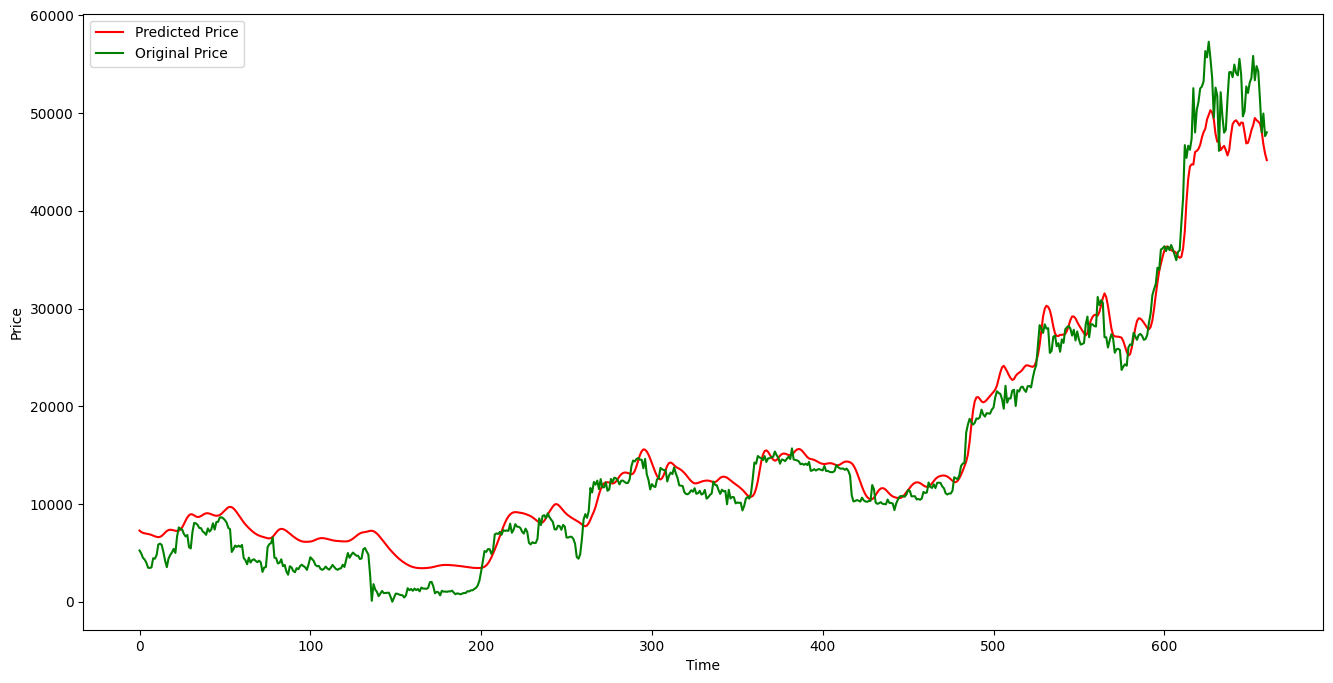

In [19]:
plt.figure(figsize=(16,8))
plt.plot(y_predict, 'r', label='Predicted Price')
plt.plot(y_test, 'g', label='Original Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [20]:
model.save('model_price_prediction.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [21]:
from keras.models import load_model

model = load_model('model_price_prediction.h5')

In [22]:
import yfinance as yf
import pandas as pd

# Load data
start_date = "2014-09-17"
end_date = "2024-04-18"
symbol = "BTC-USD"
data = yf.download(symbol, start_date, end_date)
data.reset_index(inplace=True)

[*********************100%%**********************]  1 of 1 completed


In [24]:
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
3495,2024-04-12,70061.382812,71222.742188,65254.835938,67195.867188,67195.867188,44129299406
3496,2024-04-13,67188.375000,67931.429688,60919.105469,63821.472656,63821.472656,52869738185
3497,2024-04-14,63836.230469,65824.429688,62205.851562,65738.726562,65738.726562,49084320047
3498,2024-04-15,65739.648438,66878.648438,62332.070312,63426.210938,63426.210938,43595917654
3499,2024-04-16,63419.296875,64355.667969,61716.402344,63811.863281,63811.863281,42847528078


In [23]:
data['Close'].iloc[-1]

63811.86328125

### Prediction

In [84]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
import requests
from io import BytesIO
import urllib.request

# Load the trained model
github_url = "https://github.com/dkalenov/ML-Stock-Crypto-Trading/raw/2_supervised-learning/model_price_prediction.h5"
urllib.request.urlretrieve(github_url, 'model_price_prediction.h5')
model = load_model('model_price_prediction.h5')

# Define the start and end dates for data retrieval
start_date = "2022-03-17"
end_date = "2024-04-18"
symbol = "BTC-USD"

# Download data from Yahoo Finance
data = yf.download(symbol, start_date, end_date)
data.reset_index(inplace=True)

# Remove rows with missing values
data.dropna(inplace=True)

# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data['Close'].values.reshape(-1,1))

# Prepare data for input to the model
x_input = data_scaled[-100:].reshape(1,-1,1)

# Predict the price for the next day
predicted_price = model.predict(x_input)

# Inverse scale the predicted data
predicted_price = scaler.inverse_transform(predicted_price)

# Print the predicted price for the next day
print("Predicted Price for", data['Date'].iloc[-1].strftime("%Y-%m-%d"), ":", predicted_price[0][0])

[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 1s 1s/step
Predicted Price for 2024-04-17 : 61845.39


In [72]:
data.tail(10)

,Date,Open,High,Low,Close,Adj Close,Volume
753,2024-04-08,69362.554688,72715.359375,69064.242188,71631.359375,71631.359375,37261432669
754,2024-04-09,71632.500000,71742.507812,68212.921875,69139.015625,69139.015625,36426900409
755,2024-04-10,69140.242188,71093.429688,67503.562500,70587.882812,70587.882812,38318601774
756,2024-04-11,70575.734375,71256.234375,69571.812500,70060.609375,70060.609375,30153382941
757,2024-04-12,70061.382812,71222.742188,65254.835938,67195.867188,67195.867188,44129299406
758,2024-04-13,67188.375000,67931.429688,60919.105469,63821.472656,63821.472656,52869738185
759,2024-04-14,63836.230469,65824.429688,62205.851562,65738.726562,65738.726562,49084320047
760,2024-04-15,65739.648438,66878.648438,62332.070312,63426.210938,63426.210938,43595917654
761,2024-04-16,63419.296875,64355.667969,61716.402344,63811.863281,63811.863281,42847528078
762,2024-04-17,63826.062500,64442.621094,60951.066406,61291.476562,61291.476562,37514571776


In [85]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model

# Load the trained model
import requests
import urllib.request

github_url = "https://github.com/dkalenov/ML-Stock-Crypto-Trading/raw/2_supervised-learning/model_price_prediction.h5"
urllib.request.urlretrieve(github_url, 'model_price_prediction.h5')

model = load_model('model_price_prediction.h5')

# Define the start and end dates for data retrieval
end_date = pd.to_datetime('today').strftime('%Y-%m-%d')
start_date = pd.to_datetime(end_date) - pd.DateOffset(months=1)
symbol = "BTC-USD"

# Download data from Yahoo Finance
data = yf.download(symbol, start_date, end_date)
data.reset_index(inplace=True)

# Remove rows with missing values
data.dropna(inplace=True)

# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data['Close'].values.reshape(-1,1))

# Prepare data for input to the model
window_size = 100
x_input = []
for i in range(window_size, len(data_scaled)):
    x_input.append(data_scaled[i-window_size:i, 0])

x_input = np.array(x_input)
x_input = np.reshape(x_input, (x_input.shape[0], x_input.shape[1], 1))

# Predict the prices for the next month
predicted_prices = model.predict(x_input)
predicted_prices = scaler.inverse_transform(predicted_prices)

# Add the predicted prices to the DataFrame
predicted_dates = pd.date_range(start=end_date, periods=len(predicted_prices))
predicted_data = pd.DataFrame({'Date': predicted_dates, 'Close': predicted_prices.flatten()})

# Plot the actual and predicted prices
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Close'], label='Actual Price', color='blue')
plt.plot(predicted_data['Date'], predicted_data['Close'], label='Predicted Price', color='red')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Prices')
plt.legend()
plt.show()

[*********************100%%**********************]  1 of 1 completed


IndexError: tuple index out of range